In [1]:
import sys
import subprocess
import os
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

try:
    if 'google.colab' in str(get_ipython()):
        logging.info("Running in Google Colab.")

        # Installing required packages
        logging.info("Installing required packages...")
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "polars", "pandas", "seaborn", "matplotlib", "plotnine", "great-tables"],
            capture_output=True,
            text=True
        )
        logging.info(f"Pip install output:\n{result.stdout}")
        if result.stderr:
            logging.warning(f"Pip install errors:\n{result.stderr}")

        # Creating data directory if it doesn't exist
        data_dir = "data"
        os.makedirs(data_dir, exist_ok=True)
        logging.info(f"Ensured '{data_dir}' directory exists.")

        # Downloading sales CSV file only if it doesn't exist
        file_path = os.path.join(data_dir, "sales_update202504.csv")

        if not os.path.exists(file_path):
            logging.info(f"File '{file_path}' not found. Downloading...")
            result = subprocess.run(
                ["wget", "-O", file_path,
                 "https://github.com/jxareas/data/blob/master/sales_update202504.csv?raw=true"],
                capture_output=True,
                text=True
            )
            logging.info(f"Wget output:\n{result.stdout}")
            if result.stderr:
                logging.warning(f"Wget errors:\n{result.stderr}")
        else:
            logging.info(f"File '{file_path}' already exists. Skipping download.")
except NameError:
    logging.warning("Not running in an IPython/Colab environment. Skipping package installation.")


In [2]:
# Libraries
import marimo as mo
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from typing import Literal, get_args, TypeAlias, Optional, TypedDict, Dict, Any
from great_tables import GT, style, md
import re
from functools import cached_property
from plotnine import ggplot, aes, geom_point, geom_smooth, theme_minimal, labs, scale_color_manual

# Logging configuration
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# Styling configuration
StylePresetKey = Literal["default", "alert", "soft_pink"]


class StylePreset(TypedDict):
    style: int
    style_color: str


STYLE_PRESETS: Dict[StylePresetKey, StylePreset] = {
    "default": {"style": 1, "style_color": "gray"},
    "alert": {"style": 3, "style_color": "red"},
    "soft_pink": {"style": 4, "style_color": "pink"},
    "bluey": {"style": 1, "style_color": "blue"},
    "forest": {"style": 2, "style_color": "green"},
}

# Parameters
LOCAL_PATH_TO_SALES_CSV = "./data/sales_update202504.csv"
TABLE_STYLE_FOR_NB = "bluey"

## Funciones Auxiliares

In [3]:
def github_file_url(owner: str, repo: str, file: str, branch: str = "master") -> str:
    """
    Generate the direct URL to a raw file hosted in a GitHub repository.

    Args:
        owner (str): GitHub username or organization that owns the repository.
        repo (str): Name of the GitHub repository.
        file (str): Path to the file within the repository.
        branch (str): Branch where the file is located (default is 'master').

    Returns:
        str: URL to access the raw file directly.
    """
    return f"https://github.com/{owner}/{repo}/blob/{branch}/{file}?raw=true"

In [4]:
FetchStrategy = Literal["local", "remote", "local_then_remote"]


def load_data(
    local_path: str,
    remote_path: str,
    fetch_strategy: FetchStrategy = "local_then_remote",
    csv_read_args: Dict[str, Any] = None,
) -> pl.LazyFrame:
    """
    Generic lazy CSV loader with flexible fetch strategies.

    Args:
        local_path (str): Path to local CSV file.
        remote_path (str): URL to remote CSV file.
        fetch_strategy (FetchStrategy): 'local', 'remote', or 'local_then_remote'.
        csv_read_args (dict, optional): Additional arguments to pass to Polars CSV reader.

    Returns:
        LazyFrame: Polars LazyFrame representing the loaded CSV.

    Raises:
        ValueError: If fetch_strategy is invalid.
        FileNotFoundError: If 'local' strategy and local file missing.
    """

    if csv_read_args is None:
        csv_read_args = {
            "separator": ";",
            "decimal_comma": True,
            "encoding": "latin1",
        }

    if fetch_strategy == "local":
        logger.info(f"Fetching CSV lazily from local source at: '{local_path}'")
        try:
            with open(local_path, "r"):
                pass
            logger.info(f"Local file found and loading: '{local_path}'")
        except FileNotFoundError:
            raise FileNotFoundError(f"Local file not found at: '{local_path}'")
        return pl.scan_csv(source=local_path, **csv_read_args)

    elif fetch_strategy == "remote":
        logger.info(f"Fetching CSV lazily from remote source at: {remote_path}")
        return pl.scan_csv(source=remote_path, **csv_read_args)

    elif fetch_strategy == "local_then_remote":
        try:
            lf = load_data(
                local_path=local_path,
                remote_path=remote_path,
                fetch_strategy="local",
                csv_read_args=csv_read_args,
            )
            logger.info(f"SUCCESSFULLY loaded local file: '{local_path}'")
            return lf
        except FileNotFoundError:
            logger.warning(f"Local file not found at: '{local_path}', falling back to remote.")
            lf = load_data(
                local_path=local_path,
                remote_path=remote_path,
                fetch_strategy="remote",
                csv_read_args=csv_read_args,
            )
            logger.info(f"SUCCESSFULLY loaded remote file: '{remote_path}'")
            return lf

    else:
        raise ValueError(
            f"Invalid fetch_strategy: {fetch_strategy!r}. "
            f"Expected one of: {', '.join(repr(s) for s in get_args(FetchStrategy))}."
        )

In [5]:
def make_null_count_lf(lf: pl.LazyFrame) -> pl.LazyFrame:
    """
    Computes the count and percentage of null values for each column in a Polars LazyFrame.

    This function calculates the number of nulls per column and the corresponding
    percentage of null values relative to the total number of rows. It returns
    a new LazyFrame with columns representing the variable name, null count, and
    null percentage, sorted by null count in descending order.

    Args:
        lf (pl.LazyFrame): Input Polars LazyFrame to analyze.

    Returns:
        pl.LazyFrame: A LazyFrame with three columns:
            - "variable" (str): The name of each column in the input LazyFrame.
            - "null_count" (int): The count of null values in each column.
            - "null_percentage" (float): The percentage of null values relative to
              the total number of rows, rounded to two decimal places.

    Raises:
        pl.ComputeError: If there is an error computing null counts or collecting the schema.

    Notes:
        - The total row count is computed eagerly via `.collect()` to accurately
          calculate the null percentages.
        - The returned LazyFrame is sorted in descending order by null count,
          so columns with the most missing data appear first.
        - This function is intended for data exploration and quality assessment
          in lazy execution pipelines.

    Example:
        >>> lf = pl.LazyFrame({
        ...     "a": [1, None, 3],
        ...     "b": [None, None, 3]
        ... })
        >>> null_stats = make_null_count_lf(lf).collect()
        >>> print(null_stats)
        shape: (2, 3)
        ┌──────────┬────────────┬─────────────────┐
        │ variable ┆ null_count ┆ null_percentage │
        │ ---      ┆ ---        ┆ ---             │
        │ str      ┆ u32        ┆ f64             │
        ╞══════════╪════════════╪═════════════════╡
        │ b        ┆ 2          ┆ 66.67           │
        │ a        ┆ 1          ┆ 33.33           │
        └──────────┴────────────┴─────────────────┘
    """
    height_expr = lf.select(pl.len()).collect().item()

    return (
        lf.null_count()
        .unpivot(variable_name="variable", value_name="null_count")
        .sort(by="null_count", descending=True)
        .with_columns((pl.col("null_count") / height_expr * 100).round(2).alias("null_percentage"))
        .lazy()
    )

In [6]:
def get_lf_shape_summary(lf: pl.LazyFrame) -> pl.DataFrame:
    """
    Generate a summary DataFrame with total rows and columns from a LazyFrame.

    Args:
        lf (pl.LazyFrame): Input LazyFrame.

    Returns:
        pl.DataFrame: A DataFrame with two rows:
                      - metric: 'Total de observaciones' or 'Total de columnas'
                      - value: corresponding counts
    """
    total_rows = lf.select(pl.len()).collect().item()
    total_cols = len(lf.collect_schema())

    return pl.DataFrame(
        {
            "metric": ["Total de observaciones", "Total de columnas"],
            "value": [total_rows, total_cols],
        }
    )

In [7]:
def gt_null_counts(
    lf: pl.LazyFrame,
    title: str = "**Valores nulos en el `dataset`**",
    subtitle: str = "Total de nulos con su respectivo porcentaje por cada variable",
    metric_label: str = "Variable",
    null_count_label: str = "Conteo de nulos",
    null_percentage_label: str = "Porcentaje de nulos",
    null_count_decimals: int = 0,
    null_percentage_scale_values: bool = False,
    null_percentage_drop_trailing_zeros: bool = True,
    null_percentage_palette: list[str] = None,
    style: StylePresetKey = "default",
) -> GT:
    """
    Generate a styled Great Tables (GT) table summarizing null counts and percentages per column.

    This function calculates null value statistics for each column in the provided Polars LazyFrame,
    returning a GT table with:
      - Null value counts per column.
      - Null value percentages relative to the total row count.

    The table supports flexible customization for titles, column labels, number formatting,
    percentage formatting, color gradients, and visual style presets.

    Args:
        lf (pl.LazyFrame): Polars LazyFrame to analyze.
        title (str, optional): Markdown-formatted table title. Defaults to a descriptive Spanish title.
        subtitle (str, optional): Markdown-formatted table subtitle.
        metric_label (str, optional): Label for the variable/column name column.
        null_count_label (str, optional): Label for the null count column.
        null_percentage_label (str, optional): Label for the null percentage column.
        null_count_decimals (int, optional): Number of decimals for null count formatting.
        null_percentage_scale_values (bool, optional): Whether to scale percentage values before formatting.
        null_percentage_drop_trailing_zeros (bool, optional): Whether to drop trailing zeros in percentages.
        null_percentage_palette (list[str], optional): Color gradient palette for the null percentage column.
            Defaults to ["lightgreen", "lightyellow", "crimson"].
        stylet (StylePresetKey, optional): Key selecting a predefined style preset controlling
            the table outline color and GT styling options. Defaults to "default".

    Returns:
        GT: A styled GT table presenting null counts and percentages, ready for display or export.

    Notes:
        - Internally calls `make_null_count_lf` to compute null statistics lazily.
        - Collecting the LazyFrame triggers data execution before GT rendering.
        - Conditional coloring is applied to the null percentage column based on the color palette.
        - Style presets unify table aesthetics across different usages.

    References:
        - Great Tables documentation: https://posit-dev.github.io/great-tables/articles/intro.html
    """
    if null_percentage_palette is None:
        null_percentage_palette = ["lightgreen", "lightyellow", "crimson"]

    null_stats_lf = make_null_count_lf(lf)
    null_stats_df = null_stats_lf.collect()

    preset = STYLE_PRESETS[style]

    return (
        GT(null_stats_df)
        .tab_header(title=md(title), subtitle=md(subtitle))
        .cols_label(
            variable=metric_label,
            null_count=null_count_label,
            null_percentage=null_percentage_label,
        )
        .fmt_number(columns="null_count", decimals=null_count_decimals)
        .fmt_percent(
            columns="null_percentage",
            scale_values=null_percentage_scale_values,
            drop_trailing_zeros=null_percentage_drop_trailing_zeros,
        )
        .data_color(columns="null_percentage", palette=null_percentage_palette)
        .opt_table_outline()
        .opt_stylize(style=preset["style"], color=preset["style_color"])
    )

In [8]:
def gt_dims(
    lf: pl.LazyFrame,
    title: str = "**Dimensiones del dataset**",
    subtitle: str = "Número total de observaciones y variables",
    metric_label: str = "Métrica",
    value_label: str = "Valor",
    style: StylePresetKey = "default",
) -> GT:
    """
    Generate a styled GT table summarizing the dimensions (rows and columns) of a Polars LazyFrame.

    This function creates a GT (Great Tables) object presenting the total number of observations
    (rows) and variables (columns) of the given Polars LazyFrame. The table is customizable
    with markdown headers, column labels, and styling presets for consistent visual appearance.

    Args:
        lf (pl.LazyFrame): The Polars LazyFrame to analyze.
        title (str, optional): Markdown-formatted table title. Defaults to "**Dimensiones del dataset**".
        subtitle (str, optional): Markdown-formatted table subtitle. Defaults to
            "Número total de observaciones (filas) y variables (columnas)".
        metric_label (str, optional): Label for the metric column (e.g., "Métrica"). Defaults to "Métrica".
        value_label (str, optional): Label for the value column (e.g., "Valor"). Defaults to "Valor".
        style (StylePresetKey, optional): Key selecting a predefined style preset for
            the table outline and color.

    Returns:
        GT: A styled GT table summarizing the row and column counts of the input LazyFrame,
            ready for display or export.

    Raises:
        KeyError: If an invalid style key is provided.

    Example:
        >>> dims_summary_gt(lf, style="alert")
        # Returns a red-outlined GT table showing dataset dimensions.
    """
    preset = STYLE_PRESETS[style]

    dims_lf = get_lf_shape_summary(lf)

    return (
        GT(dims_lf)
        .tab_header(title=md(title), subtitle=md(subtitle))
        .cols_label(metric=metric_label, value=value_label)
        .opt_table_outline()
        .opt_stylize(style=preset["style"], color=preset["style_color"])
    )

In [9]:
def value_counts_with_proportion(
    series: pl.Series,
    count_col_alias: str = "count",
    proportion_col_alias: str = "proportion",
    cum_count_col_alias: str = "cum_count",
    cum_proportion_col_alias: str = "cum_proportion",
    sort: bool = True,
    parallel: bool = True,
    decimals: int = 2,
    convert_to_pandas: bool = False,
) -> pl.DataFrame | pd.DataFrame:
    """
    Compute value counts, proportions, and cumulative frequencies for a Polars Series.

    This function extends `polars.Series.value_counts()` by adding:
    - Proportions (relative frequencies) of each unique value.
    - Cumulative absolute frequencies (running sum of counts).
    - Cumulative relative frequencies (running sum of proportions).

    Parameters
    ----------
    series : pl.Series
        Input Polars Series for which to compute value counts.
    count_col_alias : str, optional (default='count')
        Name of the column containing the count of each unique value.
    proportion_col_alias : str, optional (default='proportion')
        Name of the column containing the proportion (relative frequency) of each unique value.
    cum_count_col_alias : str, optional (default='cum_count')
        Name of the column containing the cumulative absolute frequency.
    cum_proportion_col_alias : str, optional (default='cum_proportion')
        Name of the column containing the cumulative relative frequency.
    sort : bool, optional (default=True)
        If True, sort results by count in descending order.
    parallel : bool, optional (default=True)
        If True, use multithreading for faster computation (Polars parallel execution).
    decimals : int, optional (default=2)
        Number of decimal places to round the proportion columns.
    convert_to_pandas : bool, optional (default=False)
        If True, return result as a Pandas DataFrame; otherwise, return a Polars DataFrame.

    Returns
    -------
    pl.DataFrame | pd.DataFrame
        A DataFrame with columns for:
        - Unique values (`value`),
        - Counts (`count_col_alias`),
        - Proportions (`proportion_col_alias`),
        - Cumulative counts (`cum_count_col_alias`),
        - Cumulative proportions (`cum_proportion_col_alias`).
        Return type depends on `convert_to_pandas`.

    Examples
    --------
    >>> import polars as pl
    >>> s = pl.Series(["a", "b", "a", "c", "b", "a"])
    >>> value_counts_with_proportion(s)
    shape: (3, 5)
    ┌──────┬───────┬────────────┬───────────┬──────────────────┐
    │ value │ count │ proportion │ cum_count │ cum_proportion   │
    │ ---   │ ---   │ ---        │ ---       │ ---              │
    │ str   │ u32   │ f64        │ u32       │ f64              │
    ╞══════╪═══════╪════════════╪═══════════╪══════════════════╡
    │ "a"   │ 3     │ 0.5        │ 3         │ 0.5              │
    │ "b"   │ 2     │ 0.33       │ 5         │ 0.83             │
    │ "c"   │ 1     │ 0.17       │ 6         │ 1.0              │
    └──────┴───────┴────────────┴───────────┴──────────────────┘
    """
    total_count = series.len()

    result = series.value_counts(name=count_col_alias, sort=sort, parallel=parallel).with_columns(
        (pl.col(count_col_alias) / total_count).round(decimals).alias(proportion_col_alias),
        pl.col(count_col_alias).cum_sum().alias(cum_count_col_alias),
        (pl.col(count_col_alias).cum_sum() / total_count)
        .round(decimals)
        .alias(cum_proportion_col_alias),
    )

    return result.to_pandas() if convert_to_pandas else result

In [10]:
class LazyCSVLoader:
    """
    Lazy CSV loader using Polars with optional schema typing, decimal comma support,
    snake_case renaming, and support for local and/or remote CSV paths.

    Args:
        local_path (Optional[str]): Path to local CSV file.
        remote_path (Optional[str]): URL to remote CSV file.
        separator (str, optional): CSV delimiter (default ',').
        dtypes (Optional[Dict[str, pl.DataType]]): Optional schema mapping column names to Polars types.
        use_decimal_comma (bool, optional): If True, parses decimals with comma (e.g. "3,14" as 3.14).
    """

    def __init__(
        self,
        local_path: Optional[str] = None,
        remote_path: Optional[str] = None,
        separator: str = ",",
        dtypes: Optional[Dict[str, pl.DataType]] = None,
        use_decimal_comma: bool = False,
    ):
        if local_path is None and remote_path is None:
            raise ValueError("Either local_path or remote_path must be provided.")

        self.local_path = local_path
        self.remote_path = remote_path
        self.separator = separator
        self.dtypes = dtypes
        self.use_decimal_comma = use_decimal_comma

    @cached_property
    def lazyframe(self) -> pl.LazyFrame:
        """A lazily evaluated Polars LazyFrame loaded from local or remote CSV."""
        return load_data(
            local_path=self.local_path or "",
            remote_path=self.remote_path or "",
            fetch_strategy="local_then_remote",
            csv_read_args={
                "separator": self.separator,
                "decimal_comma": self.use_decimal_comma,
                "schema_overrides": self.dtypes,
            },
        )

    def schema(self) -> pl.Schema:
        """Return the schema of the CSV as a Polars Schema object."""
        return self.lazyframe.collect_schema()

    def column_names(self) -> list[str]:
        """Return a list of column names from the CSV schema."""
        return self.schema().names()

    @staticmethod
    def to_snake_case(name: str) -> str:
        """Convert a string to snake_case."""
        return re.sub(r"[\s\-]+", "_", name.strip().lower())

    def renamed_to_snake_case(self) -> pl.LazyFrame:
        """Return a LazyFrame with columns renamed to snake_case."""
        rename_map = {col: self.to_snake_case(col) for col in self.column_names()}
        return self.lazyframe.rename(rename_map)

## Carga de Datos

In [11]:
sales_lf_loader = LazyCSVLoader(
    local_path=LOCAL_PATH_TO_SALES_CSV,
    remote_path=github_file_url(owner="jxareas", repo="data", file="sales_update202504.csv"),
    separator=";",
    use_decimal_comma=True,
)

sales_lf = sales_lf_loader.renamed_to_snake_case()

sales_lf.head(n=10).collect()

2025-06-19 08:41:53,453 - INFO - Fetching CSV lazily from local source at: './data/sales_update202504.csv'
2025-06-19 08:41:53,454 - WARNING - Local file not found at: './data/sales_update202504.csv', falling back to remote.
2025-06-19 08:41:53,454 - INFO - Fetching CSV lazily from remote source at: https://github.com/jxareas/data/blob/master/sales_update202504.csv?raw=true
2025-06-19 08:41:53,456 - INFO - SUCCESSFULLY loaded remote file: 'https://github.com/jxareas/data/blob/master/sales_update202504.csv?raw=true'


fecha_anual,inversion,ventas
i64,f64,f64
1980,1.0,4.61
1981,1.5,5.18
1982,2.0,5.09
1983,2.5,5.44
1984,3.0,0.62
1985,3.5,6.39
1986,4.0,0.64
1987,4.5,7.04
1988,5.0,7.13


## EDA - Analisis Exploratorio de Datos

### Observaciones y Variables

In [12]:
gt_dims(
    lf=sales_lf,
    title="**Dimensiones del dataset de `ventas`**",
    style=TABLE_STYLE_FOR_NB,
)

GT(_tbl_data=shape: (2, 2)
┌────────────────────────┬───────┐
│ metric                 ┆ value │
│ ---                    ┆ ---   │
│ str                    ┆ i64   │
╞════════════════════════╪═══════╡
│ Total de observaciones ┆ 46    │
│ Total de columnas      ┆ 3     │
└────────────────────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7121f0ddb5e0>, _boxhead=Boxhead([ColInfo(var='metric', type=<ColInfoTypeEnum.default: 1>, column_label='Métrica', column_align='left', column_width=None), ColInfo(var='value', type=<ColInfoTypeEnum.default: 1>, column_label='Valor', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7121f0ddbc10>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Dimensiones del dataset de `ventas`**'), subtitle=Md(text='Número total de observaciones y variables'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7121f0ddad10>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#004D80'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#004D80'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', ty

### Valores Nulos

In [13]:
gt_null_counts(
    lf=sales_lf,
    title="**Valores nulos de `ventas`**",
    style=TABLE_STYLE_FOR_NB,
)

GT(_tbl_data=shape: (3, 3)
┌─────────────┬────────────┬─────────────────┐
│ variable    ┆ null_count ┆ null_percentage │
│ ---         ┆ ---        ┆ ---             │
│ str         ┆ u32        ┆ f64             │
╞═════════════╪════════════╪═════════════════╡
│ fecha_anual ┆ 0          ┆ 0.0             │
│ inversion   ┆ 0          ┆ 0.0             │
│ ventas      ┆ 0          ┆ 0.0             │
└─────────────┴────────────┴─────────────────┘, _body=<great_tables._gt_data.Body object at 0x7121f0dd8b80>, _boxhead=Boxhead([ColInfo(var='variable', type=<ColInfoTypeEnum.default: 1>, column_label='Variable', column_align='left', column_width=None), ColInfo(var='null_count', type=<ColInfoTypeEnum.default: 1>, column_label='Conteo de nulos', column_align='right', column_width=None), ColInfo(var='null_percentage', type=<ColInfoTypeEnum.default: 1>, column_label='Porcentaje de nulos', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7121f0ddae60>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Valores nulos de `ventas`**'), subtitle=Md(text='Total de nulos con su respectivo porcentaje por cada variable'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='null_percentage', rows=[0], mask=None), grpname=None, colname='null_percentage', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#90ee90')]), StyleInfo(locname=LocBody(columns='null_percentage', rows=[1], mask=None), grpname=None, colname='null_percentage', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#90ee90')]), StyleInfo(locname=LocBody(columns='null_percentage', rows=[2], mask=None), grpname=None, colname='null_percentage', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#90ee90')])], _locale=<great_tables._gt_data.Locale object at 0x7121f0ddb3a0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7121f0dd87c0>, <great_tables._gt_data.FormatInfo object at 0x7121f0dd8a00>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_bo

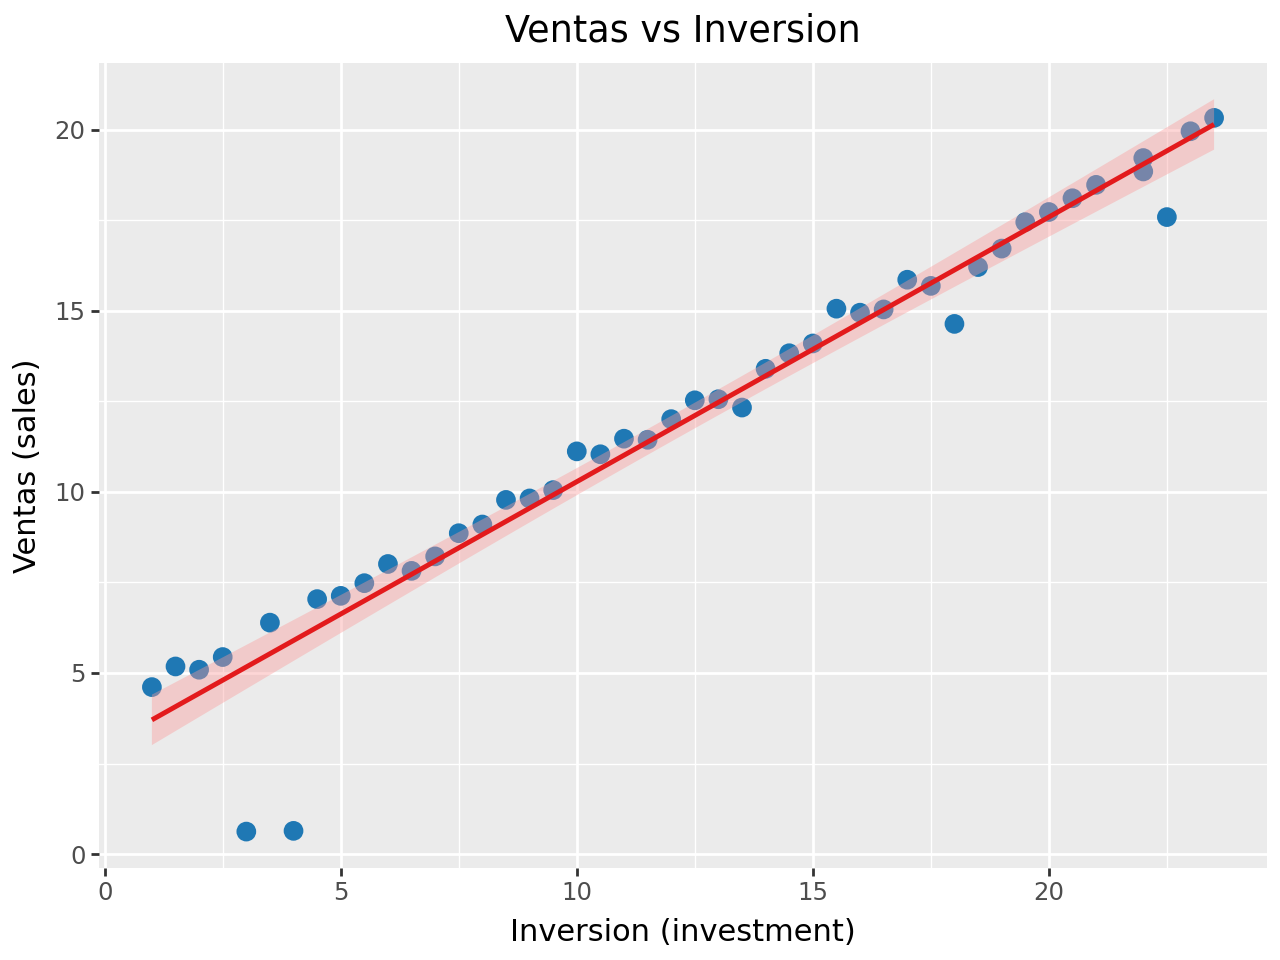

In [14]:
sales_df = sales_lf.collect()

(
    ggplot(sales_df, aes(x="inversion", y="ventas"))
    + geom_point(color="#1f78b4", size=3)
    + geom_smooth(method="lm", se=True, color="#e31a1c", fill="#fb9a99", alpha=0.4)
    + labs(title="Ventas vs Inversion", x="Inversion (investment)", y="Ventas (sales)")
).show()

## Modelo de regresión lineal

In [15]:
# Should we use statsmodels with its built-in Wilkinson-Rogers notation for SLR? (ventas ~ inversion)
import statsmodels.formula.api as smf

model = smf.ols("ventas ~ inversion", data=sales_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ventas   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     763.8
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           1.93e-29
Time:                        08:41:54   Log-Likelihood:                -72.380
No. Observations:                  46   AIC:                             148.8
Df Residuals:                      44   BIC:                             152.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9741      0.369      8.062      0.000       2.231       3.718
inversion      0.7308      0.026     27.637      0.000       0.678       0.784
==============================================================================
Omnibus:                       58.051   Durbin-Watson:                   2.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.147
Skew:                          -3.321   Prob(JB):                     2.48e-71
Kurtosis:                      14.204   Cond. No.                         29.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

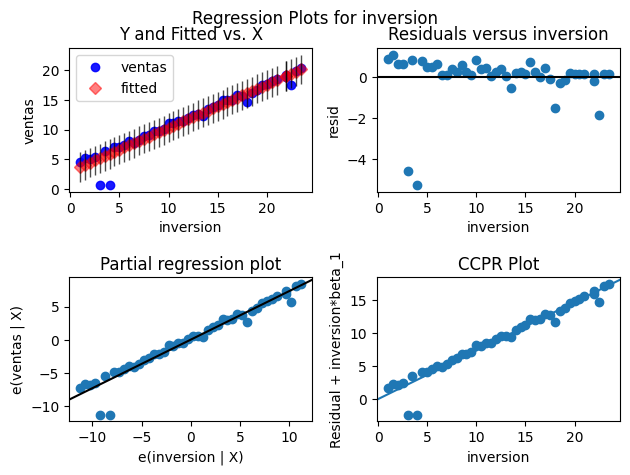

In [16]:
import statsmodels.api as sm

fig = sm.graphics.plot_regress_exog(model, "inversion")
plt.show()

## ¿Cuántas ventas se obtendrían si se invirtiesen 7 millones de euros?

In [17]:
## TBD. Replace 7 in the explanatory variable

## Evaluar el modelo a través de la SCE y el coeficiente de determinación. (5%)

In [18]:
## TBD.